In [2]:
from PID import *
import matplotlib.pyplot as plt 
import optuna
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Input
import numpy as np 
import openpyxl
from tqdm.notebook import tqdm
from openpyxl import Workbook, load_workbook

In [3]:
class Scaler:
    def __init__(self):
        self.min_vals: list[float] = None
        self.max_vals: list[float] = None

    def fit(self, X_train):
        
        self.min_vals = np.empty(X_train.shape[-1])
        self.max_vals = np.empty(X_train.shape[-1])
        
        for s in range(X_train.shape[-1]):
            self.min_vals[s] = np.min(X_train[:,:,s])
            self.max_vals[s] = np.max(X_train[:,:,s])
            
        return

    def transform(self, X):
        try:
            X_copy = np.copy(X)
            for s in range(X_copy.shape[-1]):
                X_copy[:,:,s] = (X[:,:,s] - self.min_vals[s]) / (self.max_vals[s] - self.min_vals[s])
        except:
            raise Execption("Not Fited!!!")  # noqa: F405
            
        return X_copy

    def __str__(self):
        return f"min_vals:{self.min_vals}\nmax_vals:{self.max_vals}"

    def __call__(self,X):
        return self.transform(X) 


        
def data_to_X_Y(data, window_size=2):
    
    x = []
    y = []
    
    for i in range(len(data) - window_size):
        row = [r for r in data[i:i+window_size]]  
        x.append(row)
        label = data[i+window_size][-1]
        y.append(label)
    return np.array(x), np.array(y)
        
def create_model(params: dict):
    """
    Function that automates the creation of a model based
    on the params input
    """
    
    n = params["nhidden"]
    fun1 = params["activation1"]
    l1 = params["l1"]
    l2 = params["l2"]
    dropout_rate = params["dropout_rate"]
    
    model = Sequential()
    model.add(Input((None, 3)))
    model.add(GRU(n,activation=fun1, kernel_regularizer=keras.regularizers.L1L2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(
        loss = "mse",
        optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    )

    return model

def get_offline_error(k, model):
    test = dataset_test[200:500]
    t_sim = t2[200:500]
    
    Y_off = test[:, -1]
    Y_pred = np.empty(t_sim.shape[0])
    
    Y_pred[0] = Y_off[0]
    U_off = test[:, :-1]
    
    
    Y_pred[: k + 1] = Y_off[: k + 1]
    
    for n in tqdm(range(k, t_sim.shape[0] - 1)):
        data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
        model_input = pre(data_input.reshape(-1, k, 3))
        Y_pred[n + 1] = float(model.predict(model_input, verbose=0)[0,0])

    score = mse(Y_off, Y_pred)
    return score


def mse(y1, y2):
    return np.mean(np.square(y1 - y2))

def tuna_obj(trial):

    # Decision variables
    n = trial.suggest_int('n_hidden', 1, 50)
    fun1 = trial.suggest_categorical("activation function", ["tanh", "linear"])
    window_size = trial.suggest_int("window_size", 1, 8)
    tuna_params = {
        "nhidden": n,
        "activation1": fun1,
        "window_size": window_size,
        "l1": trial.suggest_float("l1", 1e-9, 1e-2, log=True),
        "l2": trial.suggest_float("l2", 1e-9, 1e-2, log=True),
        "dropout_rate": trial.suggest_float("dr", 0.0, 0.5, step=.01),
    }
    
    tuna_model = create_model(tuna_params)

    x_tuna, y_tuna = data_to_X_Y(dataset_train, window_size = window_size)
    pre.fit(x_tuna)
    pid_x, pid_y = data_to_X_Y(pid11[:,1:], window_size)
    pid_x2, pid_y2 = data_to_X_Y(pid12[:,1:], window_size)
    pid_xfull = np.vstack([pid_x, pid_x2])
    pid_yfull = np.concatenate([pid_y, pid_y2])
    xN = pre(x_tuna)
    # fit model
    callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    tuna_model.fit(xN, y_tuna, validation_split=0.30, batch_size=128, epochs=100, callbacks=[callback],verbose=0)
    final_loss = tuna_model.history.history["loss"][-1]
    final_val_loss = tuna_model.history.history["val_loss"][-1]
    test_loss = mse(tuna_model.predict(pre(pid_xfull)), pid_yfull)
    offline_score = get_offline_error(window_size, tuna_model)

    wb = load_workbook(filename)
    ws = wb.active
    ws.append(list(tuna_params.values()) + [final_loss, final_val_loss, test_loss, offline_score])
    wb.save(filename)
    wb.close()
        
    # Exporting best model
    trial.set_user_attr('tuna_params', tuna_params)
    trial.set_user_attr('model', tuna_model)
    
    return offline_score

In [4]:
# Data Loading
print("LOADING DATA")
dataset_train = np.loadtxt("data/PID_data.csv", delimiter=",")
dataset_test = np.loadtxt("data/PID_data_test.csv", delimiter=",")

pid11 = np.loadtxt("results/PID/PID_reg.csv", delimiter=",")
pid12 = np.loadtxt("results/PID/PID_servo.csv", delimiter=",")

t = dataset_train[:,0]
t2 = dataset_test[:,0]

dt = t[1] - t[0]

dataset_train = dataset_train[:, 1:]
dataset_test = dataset_test[:, 1:]

x_train, _ = data_to_X_Y(dataset_train)

pre = Scaler()
pre.fit(x_train)

print(pre)

filename = "results/GRU/modeling.xlsx"

print("DATA LOADED")

LOADING DATA
min_vals:[7.775      0.00948761 6.09657936]
max_vals:[23.325       4.98955436  9.5441056 ]
DATA LOADED


In [5]:
minimal_params = {
    "n_hdden":1,
    "activation function": "tanh",
    "l1":1e-9,
    "l2":1e-9,
    "dr":0.1,
    "window_size":1
}

In [6]:
import pickle 
try:
    with open("tuna_study.obj", "rb") as file:
        study = pickle.load(file)
        print("STUDY LOADED")
except:
    study = optuna.create_study()
    study.enqueue_trial(minimal_params)
    wb = Workbook()
    ws = wb.active
    ws.title = "GRU"
    ws.append(list(minimal_params.keys()) + ["train loss", "val loss", "test loss", "offline loss"])
    wb.save(filename)
    wb.close()

study.optimize(tuna_obj, timeout=60*15) #timeout = seconds to run

with open("tuna_study.obj", "wb") as file:
    pickle.dump(study, file)

STUDY LOADED
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  0%|          | 0/294 [00:00<?, ?it/s]

[I 2024-08-14 22:16:56,445] Trial 102 finished with value: 0.20634624996260142 and parameters: {'n_hidden': 27, 'activation function': 'linear', 'window_size': 5, 'l1': 1.1728590616098962e-06, 'l2': 5.2869644186981515e-06, 'dr': 0.22}. Best is trial 96 with value: 0.05557053542185644.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  0%|          | 0/294 [00:00<?, ?it/s]

[I 2024-08-14 22:20:11,557] Trial 103 finished with value: 0.12300080356976238 and parameters: {'n_hidden': 29, 'activation function': 'linear', 'window_size': 5, 'l1': 9.249519840115023e-06, 'l2': 1.9783940830460658e-05, 'dr': 0.04}. Best is trial 96 with value: 0.05557053542185644.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  0%|          | 0/294 [00:00<?, ?it/s]

[I 2024-08-14 22:21:06,115] Trial 104 finished with value: 0.2663320589709083 and parameters: {'n_hidden': 7, 'activation function': 'linear', 'window_size': 5, 'l1': 2.5640036565135807e-06, 'l2': 2.6607899821615e-07, 'dr': 0.06}. Best is trial 96 with value: 0.05557053542185644.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  0%|          | 0/291 [00:00<?, ?it/s]

[I 2024-08-14 22:22:42,043] Trial 105 finished with value: 0.28863569316436394 and parameters: {'n_hidden': 3, 'activation function': 'linear', 'window_size': 8, 'l1': 7.237391557408364e-07, 'l2': 3.9343065809587603e-07, 'dr': 0.24}. Best is trial 96 with value: 0.05557053542185644.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  0%|          | 0/294 [00:00<?, ?it/s]

[I 2024-08-14 22:23:47,189] Trial 106 finished with value: 0.20047853087541279 and parameters: {'n_hidden': 16, 'activation function': 'linear', 'window_size': 5, 'l1': 3.8312581514881314e-08, 'l2': 1.0872298981752918e-06, 'dr': 0.2}. Best is trial 96 with value: 0.05557053542185644.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  0%|          | 0/294 [00:00<?, ?it/s]

[I 2024-08-14 22:25:24,933] Trial 107 finished with value: 0.08990904799619111 and parameters: {'n_hidden': 24, 'activation function': 'tanh', 'window_size': 5, 'l1': 1.3604900903111605e-05, 'l2': 2.712404794104206e-06, 'dr': 0.26}. Best is trial 96 with value: 0.05557053542185644.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  0%|          | 0/294 [00:00<?, ?it/s]

[I 2024-08-14 22:26:53,996] Trial 108 finished with value: 0.07657677603061742 and parameters: {'n_hidden': 20, 'activation function': 'linear', 'window_size': 5, 'l1': 1.8521671187299887e-07, 'l2': 1.4577661292943524e-07, 'dr': 0.0}. Best is trial 96 with value: 0.05557053542185644.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


  0%|          | 0/294 [00:00<?, ?it/s]

[I 2024-08-14 22:28:56,799] Trial 109 finished with value: 0.4505715547714287 and parameters: {'n_hidden': 21, 'activation function': 'linear', 'window_size': 5, 'l1': 1.2359423870286162e-07, 'l2': 1.4236321467501503e-07, 'dr': 0.01}. Best is trial 96 with value: 0.05557053542185644.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  0%|          | 0/293 [00:00<?, ?it/s]

[I 2024-08-14 22:30:50,957] Trial 110 finished with value: 0.12281229423187902 and parameters: {'n_hidden': 20, 'activation function': 'linear', 'window_size': 6, 'l1': 7.799379753678848e-08, 'l2': 4.3732929356276264e-07, 'dr': 0.0}. Best is trial 96 with value: 0.05557053542185644.


In [7]:
# Obtaining the best model and saving it
best_trial = study.best_trial
best_model = best_trial.user_attrs['model']
best_model.save('models/best_model.keras')

del(best_model)
best_model = keras.models.load_model("models/best_model.keras")

# Saving its best parameters
best_params = best_trial.user_attrs['tuna_params']
with open('models/best_model_params.txt', 'w') as f:
    for key, value in best_params.items():
        f.write(f'{key}: {value}\n')

In [8]:
dt = 0.5
k = best_params["window_size"]
test = dataset_test[200:500]
t_sim = t2[200:500]

Y_off = test[:, -1]
Y_pred = np.empty(t_sim.shape[0])

Y_pred[0] = Y_off[0]
U_off = test[:, :-1]

Y_pred[: k + 1] = Y_off[: k + 1]

for n in tqdm(range(k, t_sim.shape[0] - 1)):
    data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
    model_input = pre(data_input.reshape(-1, k, 3))
    Y_pred[n + 1] = float(best_model.predict(model_input, verbose=0)[0,0])

  0%|          | 0/295 [00:00<?, ?it/s]

0.05557053542185644


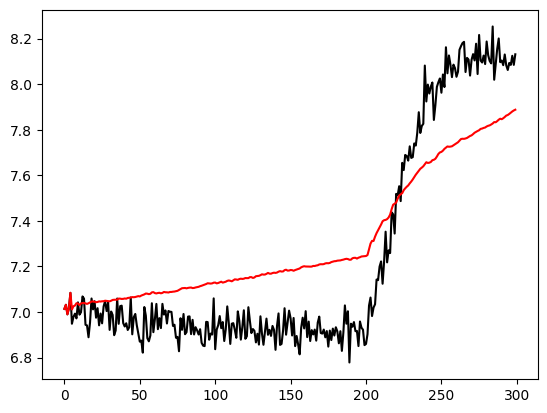

In [9]:
print(mse(Y_off, Y_pred))
plt.plot(Y_off, c='k')
plt.plot(Y_pred, c='r')
np.savetxt("results/GRU/offline.csv",np.column_stack((Y_off, Y_pred)), delimiter=",")

In [10]:
print(pre)

min_vals:[7.775      0.00948761 6.09657936]
max_vals:[23.325       4.98955436  9.5441056 ]


In [11]:
with open("models/preprocessor.obj", "wb") as f:
    pickle.dump(pre, f)

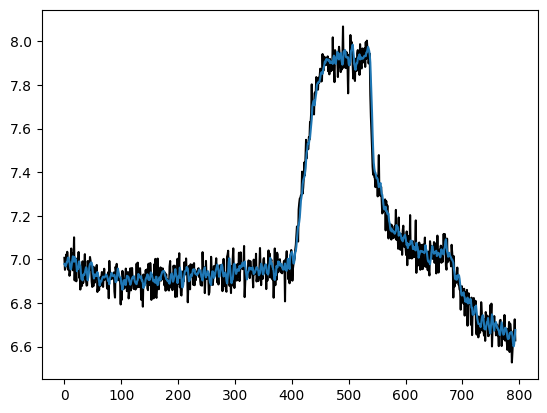

In [12]:
pid_x, pid_y = data_to_X_Y(pid11[:,1:], k)
pid_x2, pid_y2 = data_to_X_Y(pid12[:,1:], k)
pid_xfull = np.vstack([pid_x, pid_x2])
pid_yfull = np.concatenate([pid_y, pid_y2])

plt.plot(pid_yfull, c='k')
plt.plot(best_model(pre(pid_xfull)))